# Model selection demo

## Lasso and Adaptive lasso

In the lecture we talked about ridge and lasso regression. Both of these methods adress the high estimation variance that results from either high dimensional settings or high correlations between features. Estimation variance directly impacts predictive performance so surpressing estimation variance can be essential.

However, both ridge and lasso lead to *biased* estimates of the model coefficients. Increased bias can lead to a deterioration of predictive performance. Thus, we need to find a balance between increasing bias and decreasing estimation variance. This is usually done by selection our penalty/regularzation tuning parameter via cross-validation.

An alternative is to *de-bias* the estimate. 

Let's consider the form for the ridge and lasso estimates (for the simple case of uncorrelated features): 

$$\hat{\beta}_{ridge} = \frac{\hat{\beta}}{1+\lambda} $$
$$\hat{\beta}_{lasso} = (\mid\hat{\beta}\mid - \lambda)^{+} sgn(\hat{\beta})$$

The bias for the ridge estimates are larger for larger $\beta$ whereas the bias for lasso is a constant $\lambda$. Still, if we could retain the selection property of lasso *and* remove the bias, this would be even better still!

If we knew which coefficients were truly non-zero we shouldn't penalize these but only those that we want to "select out" from the model. Of course, we don't know this but by running e.g. ridge first we do get a sense for which coefficients are large and which are near 0. 

This is the motivation for *adaptive lasso*. 

Let assume we have an (near) unbiased estimate, $\hat{\beta}_u$, which we obtain from either OLS or ridge regression with a small degree of regularization. We then use these estimates to adjust the penalty for each coefficient $j$ as
$$\lambda_j = \bigl( \frac{\lambda}{\mid \hat{\beta}_{u,j} \mid^{\gamma}}\bigr),$$
where $\gamma > 0$ leads to slightly different debiasing and selection results (see paper I posted with the lecture).  

This means that those ridge coefficient estimates that are large are penalized less in the adaptive lasso step and those with small ridge coefficients are penalized more and may be set to 0 (sparse model). 



In [1]:
install.packages("glmnet")

Installing package into 'C:/Users/jornsten/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'glmnet' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jornsten\AppData\Local\Temp\RtmpUzdxfY\downloaded_packages


In [2]:
library(glmnet)
library(MASS)

standardize <- function(x) {
  x <- (x - mean(x)) / sd(x)
}

set.seed(100100)

ns<-100                    # sample size
noiselev<-0.2              # noiselevel
p<-c(10,10,10,50)          # how many features in each of 4 groups - change as you will
ps<-sum(p)                 # total number of features
pr<-0.1                    # proportion of features in true model
sigmean<-6                 # signal strength - how large true coefficients are is controlled
sigs<-2                    # spread of values of true coefficients is controlled by this
#
# I will generate 3 groups of variables that are correlated
grcorr1<-1                 # smaller value here makes xs in each group more correlated
grcorr2<-1                 # because it's how much noise I add to copies of identical features in the groups
grcorr3<-1
#
Truth<-rep(0,ps)
Truth<-round(rbinom(n=ps,size=1,prob=pr))  # generates the true model, either at random or by choice
#
nt<-sum(Truth)
tr.coef<-rnorm(nt,mean=sigmean,sd=sigs)*sign(rbinom(n=nt,size=1,prob=.5)*2-1) # true coefficient values
all.coef<-rep(0,ps)
all.coef[Truth==1]<-tr.coef
# 
# 
# create the x variabes in 3 correlated groups
x1<-rnorm(ns)
x1<-matrix(rep(x1,p[1]),ns,p[1],byrow=F)+matrix(rnorm(ns*p[1],sd=grcorr1),ns,p[1])
x1<-apply(x1,2,standardize)
#
x2<-rnorm(ns)
x2<-matrix(rep(x2,p[2]),ns,p[2],byrow=F)+matrix(rnorm(ns*p[2],sd=grcorr2),ns,p[2])
x2<-apply(x2,2,standardize)
#
x3<-rnorm(ns)
x3<-matrix(rep(x3,p[3]),ns,p[3],byrow=F)+matrix(rnorm(ns*p[3],sd=grcorr3),ns,p[3])
x3<-apply(x3,2,standardize)
#  a fourth group with no correlation
x4<-matrix(rnorm(ns*p[4]),ns,p[4])
x4<-apply(x4,2,standardize)
# creating the response...
y<-cbind(x1,x2,x3,x4)%*%all.coef+rnorm(ns)*noiselev
df<-as.data.frame(cbind(x1,x2,x3,x4,y))
names(df)<-c(as.character(seq(1,ps)),"y")
# ...and a test data set
y.new<-cbind(x1,x2,x3,x4)%*%all.coef+rnorm(ns)*noiselev
df.new<-as.data.frame(cbind(x1,x2,x3,x4,y.new))
names(df.new)<-c(as.character(seq(1,ps)),"y")
#### Now data set is created
# Run OLS if possible
if (ns>ps) {
    mm<-lm(y~., data=df)
    Coeflm<-mm$coef[-1]
    pm<-predict(mm,newdata=df.new)
    MSElm<-sum((y.new-pm)^2)/length(pm) }
#
# Run lasso
cv.gg<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y)
CoefLasso<-coef(cv.gg,s="lambda.1se")[-1]
pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg,s="lambda.1se")
MSELasso<-sum((y.new-pm)^2)/length(pm)
# Run ridge  - not you can try different lambdas here of course
ma<-lm.ridge(y~., data=df,lambda=1)
CoefRidge<-coef(ma)[-1]
pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(ma)
MSERidge<-sum((y.new-pm)^2)/length(pm)
# run adaptive lasso with ridge initialization - small lambda (try what happens with bigger lambda here)
gamma<-1
ma<-lm.ridge(y~., data=df,lambda=.01)
penf<-1/(abs(coef(ma)[-1])^gamma)
cv.gg2<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y,penalty.factor=penf)
cc<-coef(cv.gg2,s="lambda.1se")[-1]
CoefAlasso<-cc
pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg2,s="lambda.1se")
MSEalasso<-sum((y.new-pm)^2)/length(pm)
# more aggressive adaption with higher gamma
gamma<-2
penf<-1/(abs(coef(ma)[-1])^gamma)
cv.gg2<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y,penalty.factor=penf)
cc<-coef(cv.gg2,s="lambda.1se")[-1]
CoefAlasso3<-cc
pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg2,s="lambda.1se")
MSEalasso3<-sum((y.new-pm)^2)/length(pm)
# or less aggressive
gamma<-.5
penf<-1/(abs(coef(ma)[-1])^gamma)
cv.gg2<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y,penalty.factor=penf)
cc<-coef(cv.gg2,s="lambda.1se")[-1]
CoefAlasso4<-cc
pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg2,s="lambda.1se")
MSEalasso4<-sum((y.new-pm)^2)/length(pm)

Loading required package: Matrix

Loaded glmnet 4.1-8



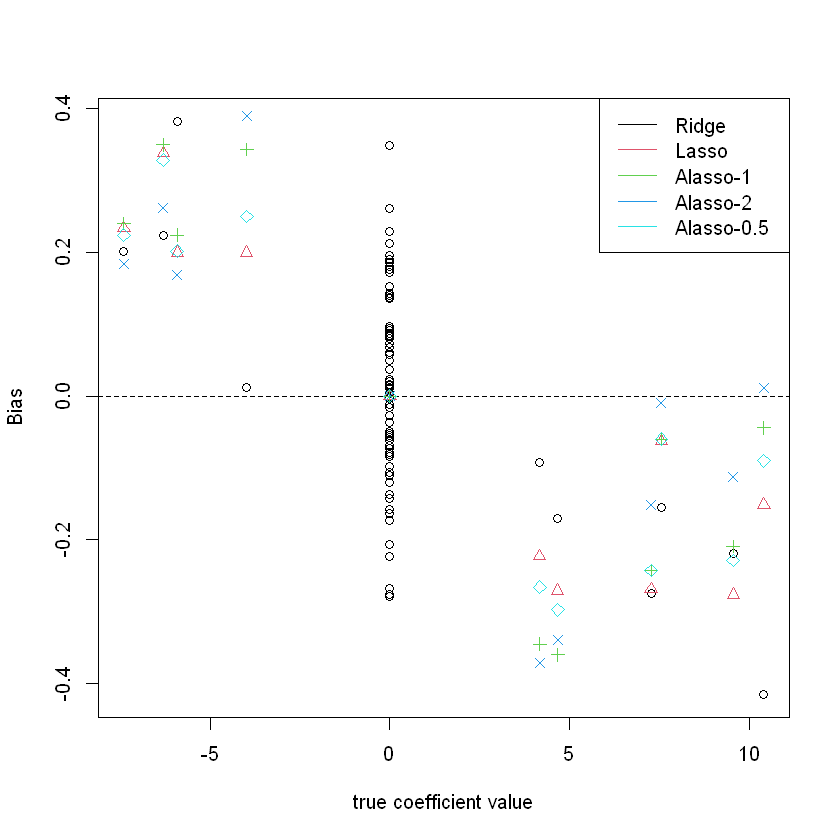

In [3]:
plot(all.coef, CoefRidge-all.coef,xlab="true coefficient value",ylab="Bias")
abline(h=0,lty=2)
points(all.coef,CoefLasso-all.coef,col=2,pch=2)
points(all.coef,CoefAlasso-all.coef,col=3,pch=3)
points(all.coef,CoefAlasso3-all.coef,col=4,pch=4)
points(all.coef,CoefAlasso4-all.coef,col=5,pch=5)
legend(x = "topright",         
       legend = c("Ridge","Lasso","Alasso-1","Alasso-2","Alasso-0.5"), 
       col = c(1,2,3,4,5),
       lwd = 1)         

Note that the ridge estimates are not sparse. All lasso methods tended to remove the 0 coefficients for the model with these settings (try with other settings at home). The bias reduction is usually more noticable for later coefficients. The cross-validation may impact "who's the winner" for different runs.

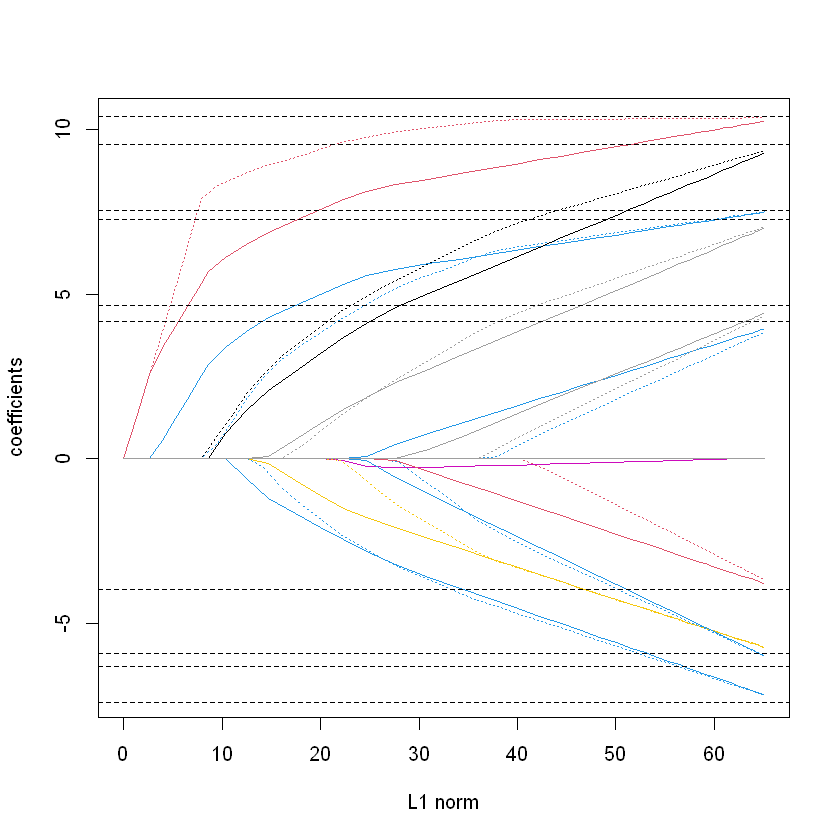

In [4]:
gg<-glmnet(x=cbind(x1,x2,x3,x4),y=y)
gamma<-1
ma<-lm.ridge(y~., data=df,lambda=.01)
penf<-1/(abs(coef(ma)[-1])^gamma)
gg2<-glmnet(x=cbind(x1,x2,x3,x4),y=y,penalty.factor=penf)
plot(apply(abs(gg$beta),2,sum),gg$beta[1,],type="l",ylim=c(min(gg$beta),max(gg$beta)),xlab="L1 norm",ylab="coefficients")
lines(apply(abs(gg2$beta),2,sum),gg2$beta[1,],lty=3)
for (bb in (2:dim(gg$beta)[1])) {
    lines(apply(abs(gg$beta),2,sum),gg$beta[bb,],col=bb)
    lines(apply(abs(gg2$beta),2,sum),gg2$beta[bb,],lty=3,col=bb)
}
for (kk in (1:length(tr.coef))) {
    abline(h=tr.coef[kk],lty=2)
}
# plotting solutions paths for lasso (solid) and adaptive lasso (dashed). Horizontal lines are the true coefficient values.

The solution paths for lasso and adaptive lasso showcases the bias reduction for the large coefficients.

Now try with different correlations, sample sizes etc.

Below, I make several runs and look at the bias for the different estimation methods as well as predictive performance and selection performance.

[1] "BIAS"
            [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
R       2.992268 4.139875 3.667571 3.853016 3.276135 3.319800 3.034510 3.438462
Lasso   2.664470 3.565051 3.380221 3.399649 3.317777 4.049142 3.539672 4.091079
aLasso  2.002150 2.253183 2.764768 2.660315 2.487104 3.584635 2.748118 3.330700
aLasso2 2.139970 2.280017 2.929660 2.704977 2.558652 3.776982 2.967143 3.505331
            [,9]    [,10]    [,11]    [,12]    [,13]    [,14]    [,15]    [,16]
R       3.376729 3.767126 2.927236 2.326812 2.317412 2.957165 2.922036 2.838067
Lasso   3.076171 4.408100 3.590300 2.439111 2.758784 2.710659 2.741145 2.843550
aLasso  2.400872 3.615416 2.801537 1.522594 1.835698 1.667067 1.717539 1.991917
aLasso2 2.599598 3.911956 3.014452 1.770450 2.012640 1.744308 1.902128 2.158181
           [,17]    [,18]
R       2.728900 2.431554
Lasso   2.583429 2.494227
aLasso  1.556868 1.602851
aLasso2 1.634207 1.741878
[1] "VARIANCE"
             [,1]     [,2]      [,3]      [,

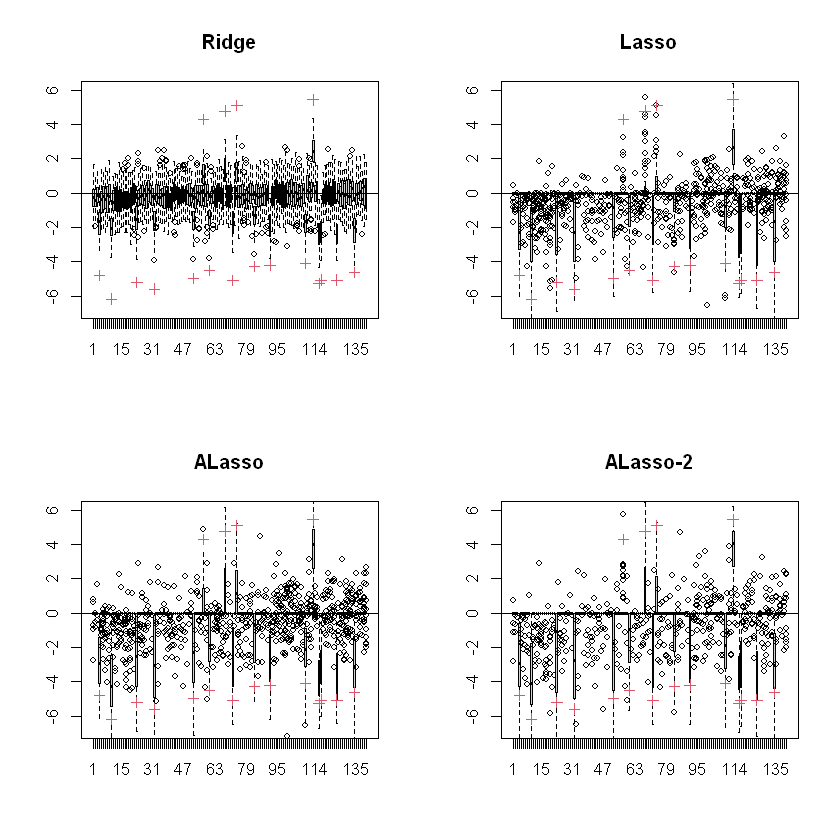

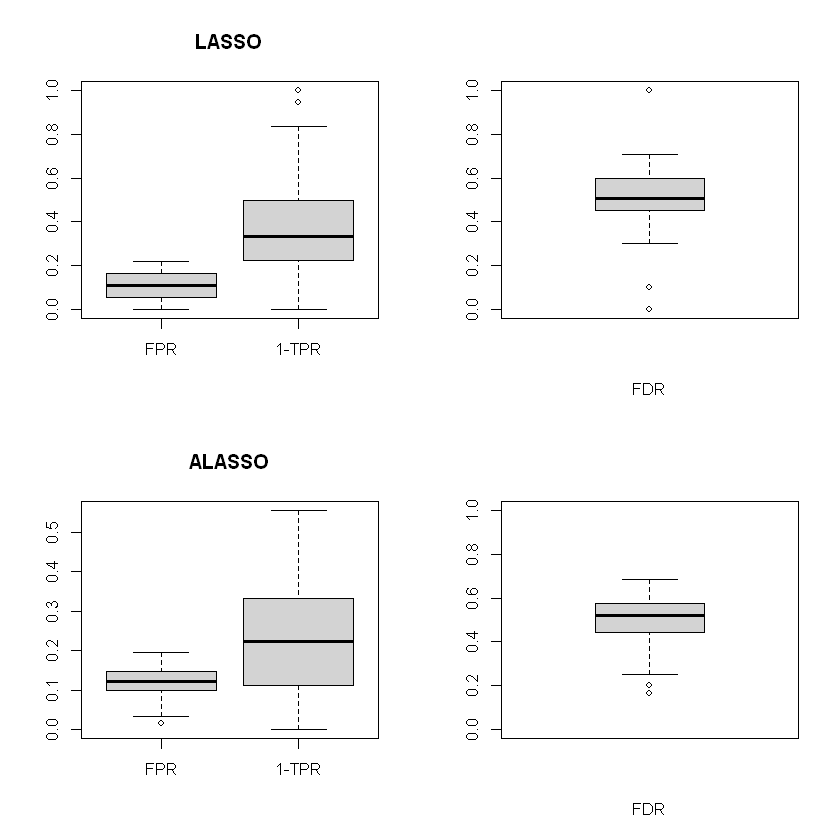

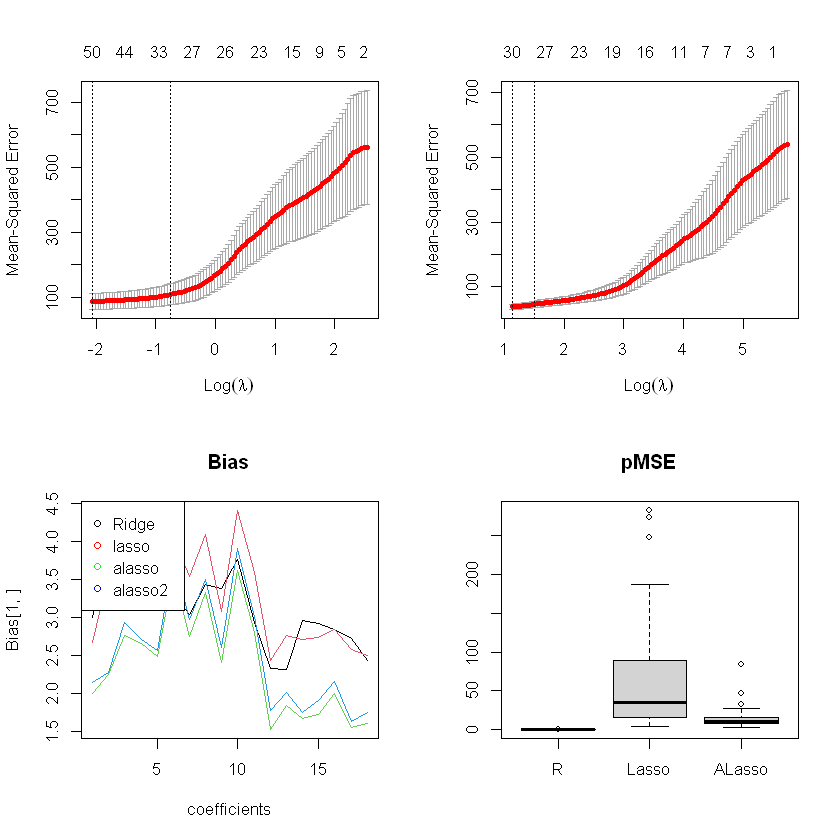

In [5]:
#### Model selection simulation ####

## Setup
library(glmnet)
library(MASS)

standardize <- function(x) {
  x <- (x - mean(x)) / sd(x)
}


set.seed(100100)
# Try different sample size (ns), noiselevel, correlation within groups of variables, size model
B<-50 # Number of times you run the loop
ns<-50                     # sample size
noiselev<-0.25             # noise level
p<-c(20,50,20,50)          # how many features in each of 4 groups - change as you will
ps<-sum(p)                 # total number of features
pr<-0.1                    # proportion of features in true model
sigmean<-5                 # signal strength - how large true coefficients are is controlled
sigs<-0.5                    # spread of values of true coefficients is controlled by this
# 3 groups of variables that are correlated
grcorr1<-1 # smaller value here makes xs in each group more correlated
grcorr2<-1
grcorr3<-1
#
Truth<-rep(0,ps)
Truth<-round(rbinom(n=ps,size=1,prob=pr))
# generates the true model, either at random or by choice
#
# create matrices to store the results across the B runs
Coeflm<-matrix(0,ps,B)
CoefR<-matrix(0,ps,B)
Coefla<-matrix(0,ps,B)
Coefala<-matrix(0,ps,B)
Coefala2<-matrix(0,ps,B)
MSElm<-matrix(0,B,1)
MSER<-matrix(0,B,1)
MSEla<-matrix(0,B,1)
MSEala<-matrix(0,B,1)
#
nt<-sum(Truth)
tr.coef<-rnorm(nt,mean=sigmean,sd=sigs)*sign(rbinom(n=nt,size=1,prob=.5)*2-1)
all.coef<-rep(0,ps)
all.coef[Truth==1]<-tr.coef
# coefficients in true model
for (b in (1:B)) {
  # create the x variabes in 3 correlated groups
  x1<-rnorm(ns)
  x1<-matrix(rep(x1,p[1]),ns,p[1],byrow=F)+matrix(rnorm(ns*p[1],sd=grcorr1),ns,p[1])
  x1<-apply(x1,2,standardize)
  #
  x2<-rnorm(ns)
  x2<-matrix(rep(x2,p[2]),ns,p[2],byrow=F)+matrix(rnorm(ns*p[2],sd=grcorr2),ns,p[2])
  x2<-apply(x2,2,standardize)
  #
  x3<-rnorm(ns)
  x3<-matrix(rep(x3,p[3]),ns,p[3],byrow=F)+matrix(rnorm(ns*p[3],sd=grcorr3),ns,p[3])
  x3<-apply(x3,2,standardize)
  #
  x4<-matrix(rnorm(ns*p[4]),ns,p[4])
  x4<-apply(x4,2,standardize)
  #
  y<-cbind(x1,x2,x3,x4)%*%all.coef+rnorm(ns)*noiselev
  df<-as.data.frame(cbind(x1,x2,x3,x4,y))
  names(df)<-c(as.character(seq(1,ps)),"y")
  ####
  y.new<-cbind(x1,x2,x3,x4)%*%all.coef+rnorm(ns)*noiselev
  df.new<-as.data.frame(cbind(x1,x2,x3,x4,y.new))
  names(df.new)<-c(as.character(seq(1,ps)),"y")
  #### Now data set is created
  # Run OLS if possible
  if (ns>ps) {
    mm<-lm(y~., data=df)
    Coeflm[,b]<-mm$coef[-1]
    pm<-predict(mm,newdata=df.new)
    MSElm[b]<-sum((y.new-pm)^2)/length(pm) }
  #
  # lasso
  cv.gg<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y)
  Coefla[,b]<-coef(cv.gg,s="lambda.1se")[-1]
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg,s="lambda.1se")
  MSEla[b]<-sum((y.new-pm)^2)/length(pm)
  #
  # adaptive lasso with ridge initialization
  gamma<-1
  ma<-lm.ridge(y~., data=df,lambda=1)
  CoefR[,b]<-coef(ma)[-1]
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(ma)
  MSER[b]<-sum((y.new-pm)^2)/length(pm)
  #
  ma<-lm.ridge(y~., data=df,lambda=.01)
  penf<-1/(abs(coef(ma)[-1])^gamma)
  cv.gg2<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y,penalty.factor=penf)
  cc<-coef(cv.gg2,s="lambda.1se")[-1]
  Coefala[,b]<-cc
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg2,s="lambda.1se")
  MSEala[b]<-sum((y.new-pm)^2)/length(pm)
  #
  # gamma=2
  gamma <- 2
  xx3<-cbind(x1,x2,x3,x4)%*%diag(abs(coef(ma)[-1])^gamma)
  gg3<-cv.glmnet(x=xx3,y=y,standardize=F)
  cc<-(coef(gg3,s="lambda.1se")[-1])*(abs(coef(ma)[-1])^gamma)
  Coefala2[,b]<-cc
  #####
}


# Result summaries
# Looking at all the coefficients
par(mfrow=c(2,2))
if (ns>ps) {
  boxplot(t(Coeflm),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="OLS") }
if (ns<=ps) {
  boxplot(t(CoefR),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="Ridge") }
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefla),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="Lasso")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefala),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="ALasso")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefala2),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="ALasso-2")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
####

if (ns>ps) {
Bias<-rbind(apply(Coeflm,1,mean)[Truth==1]-tr.coef,
            apply(CoefR,1,mean)[Truth==1]-tr.coef,
            apply(Coefla,1,mean)[Truth==1]-tr.coef,
            apply(Coefala,1,mean)[Truth==1]-tr.coef,
            apply(Coefala2,1,mean)[Truth==1]-tr.coef)

Var<-rbind(apply(Coeflm,1,var)[Truth==1],
           apply(CoefR,1,var)[Truth==1],
           apply(Coefla,1,var)[Truth==1],
           apply(Coefala,1,var)[Truth==1],
           apply(Coefala2,1,var)[Truth==1])
# bias and variance of each of the methods
row.names(Bias)<-c("LM","R","Lasso","aLasso","aLasso2")
row.names(Var)<-c("LM","R","Lasso","aLasso","aLasso2")
print("BIAS")
print(Bias)
print("VARIANCE")
print(Var)
}

if (ns<=ps) {
  Bias<-abs(rbind(apply(CoefR,1,mean)[Truth==1]-tr.coef,
              apply(Coefla,1,mean)[Truth==1]-tr.coef,
              apply(Coefala,1,mean)[Truth==1]-tr.coef,
              apply(Coefala2,1,mean)[Truth==1]-tr.coef))

  Var<-rbind(apply(CoefR,1,var)[Truth==1],
             apply(Coefla,1,var)[Truth==1],
             apply(Coefala,1,var)[Truth==1],
             apply(Coefala2,1,var)[Truth==1])
  # bias and variance of each of the methods
  row.names(Bias)<-c("R","Lasso","aLasso","aLasso2")
  row.names(Var)<-c("R","Lasso","aLasso","aLasso2")
  print("BIAS")
  print(Bias)
  print("VARIANCE")
  print(Var)
}
# Collecting selection results
TPFP<-function(Coefs,truth) {
  tr<-truth
  cp<-Coefs
  TP<-length(cp[cp!=0 & tr==1])/length(tr[tr==1])
  FP<-length(cp[cp!=0 & tr==0])/length(tr[tr==0])
  FDR<-length(cp[cp!=0 & tr==0])/length(cp[cp!=0])
  return(list(FP=FP,FDR=FDR,TP=TP))
}
# Plotting false and true positives as well as false detection rate for lasso and adaptive lasso
par(mfrow=c(2,2))
LassoSel<-apply(Coefla,2,TPFP,truth=Truth)
ll<-unlist(LassoSel)
boxplot(cbind(ll[seq(1,(B*3),by=3)],1-ll[seq(3,(B*3),by=3)]),names=c("FPR","1-TPR"),main="LASSO")
boxplot(ll[seq(2,(B*3),by=3)],xlab=c("FDR"),ylim=c(0,1))
ALassoSel<-apply(Coefala,2,TPFP,truth=Truth)
ll<-unlist(ALassoSel)
boxplot(cbind(ll[seq(1,(B*3),by=3)],1-ll[seq(3,(B*3),by=3)]),names=c("FPR","1-TPR"),main="ALASSO")
boxplot(ll[seq(2,(B*3),by=3)],xlab=c("FDR"),ylim=c(0,1))

# solution paths
plot(cv.gg)
plot(cv.gg2)
# mean bias across coefficients for the different methods
plot(Bias[1,],type="l",ylim=c(min(Bias),max(Bias)),main="Bias",xlab="coefficients")
abline(h=0)
lines(Bias[2,],col=2)
lines(Bias[3,],col=3)
lines(Bias[4,],col=4)
if (ns > ps)   {
    lines(Bias[5,],col=5)
    legend("topleft",legend=c("Lm","Ridge","lasso","alasso","alasso2"),pch=1,col=c("black","red","green","blue","cyan"))
}
if (ns <= ps) {
    legend("topleft",legend=c("Ridge","lasso","alasso","alasso2"),pch=1,col=c("black","red","green","blue"))
}

#pMSE performance for the different methods
if (ns > ps) {
   boxplot(cbind(MSElm,MSER,MSEla,MSEala),names=c("LM","R","Lasso","ALasso"),main="pMSE") }
if (ns <= ps) {
   boxplot(cbind(MSER,MSEla,MSEala),names=c("R","Lasso","ALasso"),main="pMSE") }


            [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
R       3.897784 5.149277 3.304016 3.535305 2.981375 3.006127 2.706846 3.036030
Lasso   3.033786 4.154670 2.558025 2.717177 2.333483 3.440439 2.634268 3.366372
aLasso  2.979858 3.572062 2.189936 1.990551 1.767869 2.914369 2.039663 2.783535
aLasso2 2.949620 4.239624 2.378666 2.249812 2.050684 3.337076 2.391084 3.200849
            [,9]    [,10]    [,11]    [,12]    [,13]    [,14]    [,15]    [,16]
R       4.402908 4.857871 3.695528 1.984406 1.970823 2.520077 2.448503 2.441941
Lasso   4.017694 5.101378 3.870798 1.623626 1.873097 1.752947 1.863167 1.801198
aLasso  4.073272 5.099793 3.777557 1.204429 1.302535 1.241291 1.335068 1.410644
aLasso2 4.483129 5.099793 4.081966 1.464996 1.491906 1.251053 1.456746 1.523203
           [,17]    [,18]
R       2.342688 2.081927
Lasso   1.584995 1.688841
aLasso  1.033988 1.151779
aLasso2 1.089787 1.319722
              [,1]      [,2]     [,3]      [,4]      [,5]      [,6]   

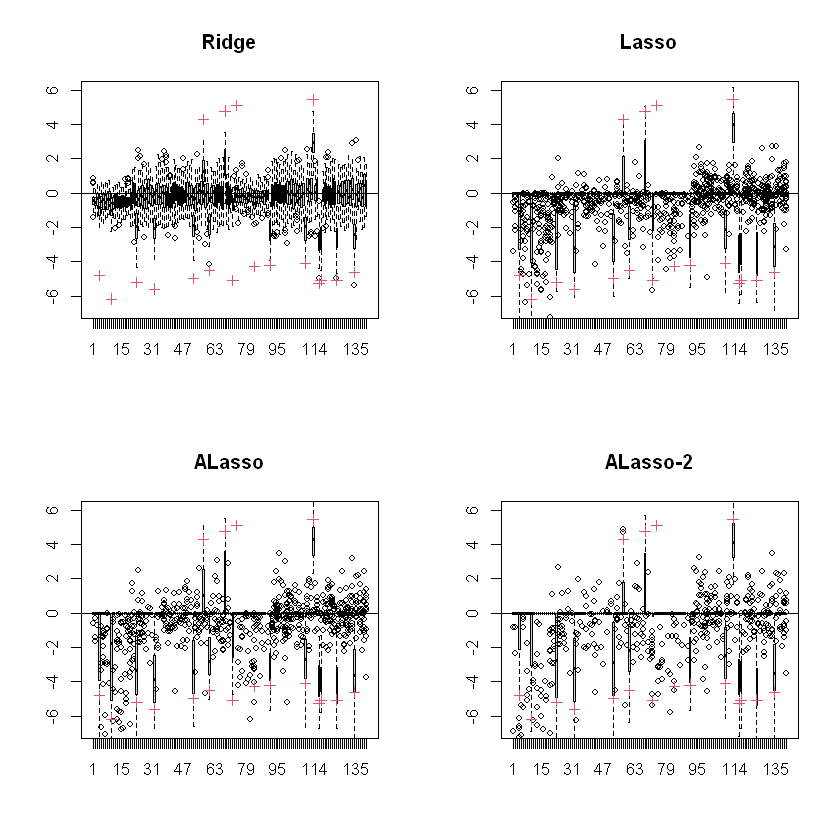

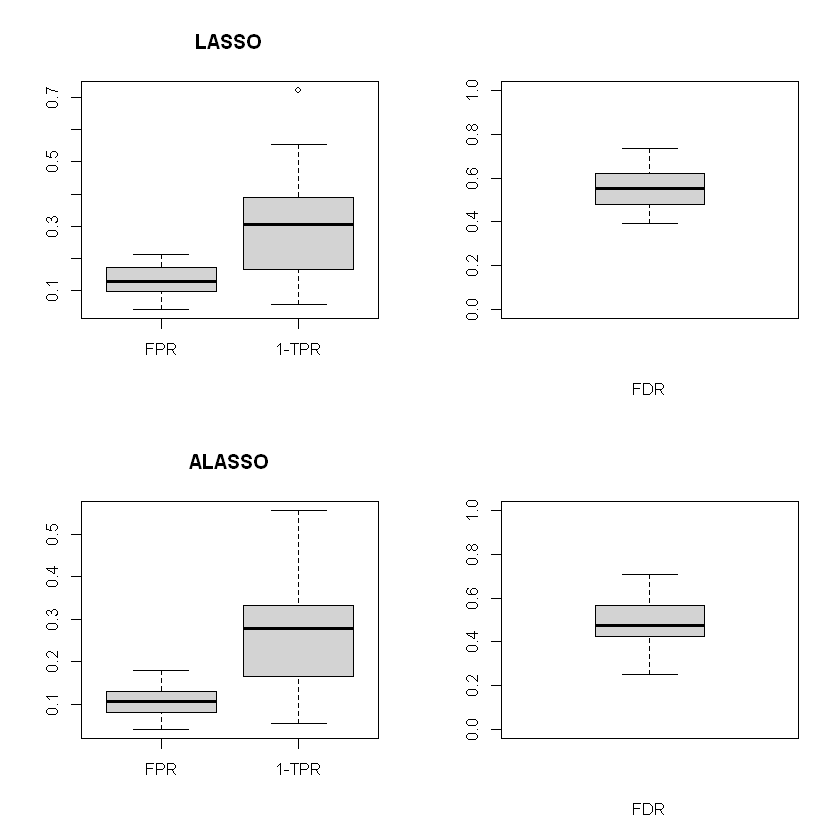

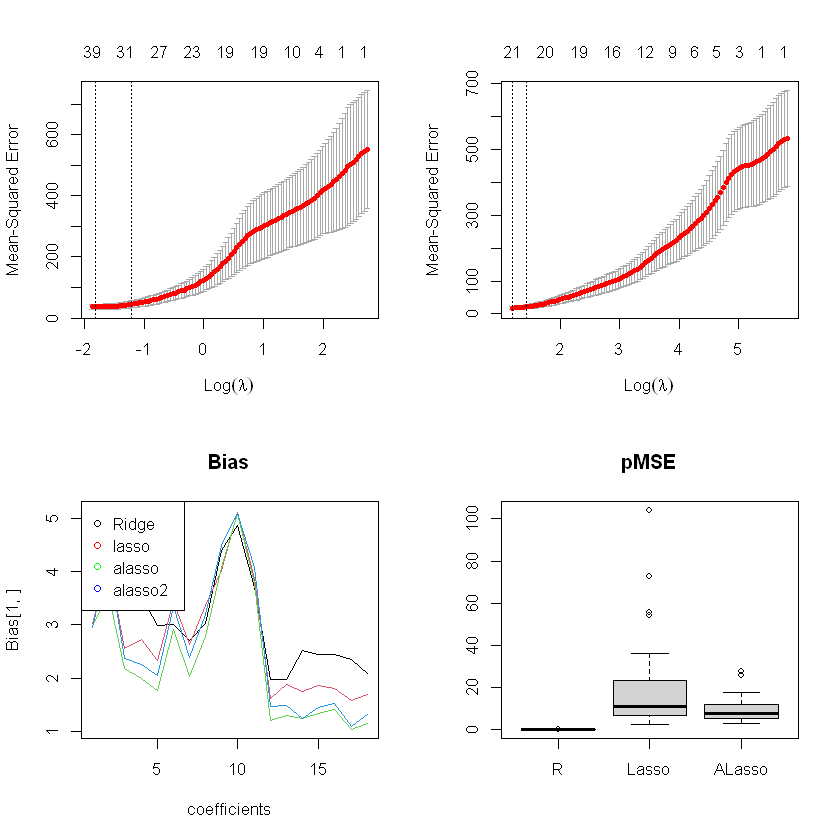

In [6]:
#### Model selection simulation ####

## Setup
library(glmnet)
library(MASS)

standardize <- function(x) {
  x <- (x - mean(x)) / sd(x)
}


set.seed(100100)
# Try different sample size (ns), noiselevel, correlation within groups of variables, size model
B<-50
ns<-50
noiselev<-0.25
p<-c(20,50,20,50) # how many features in each of 4 groups - change as you will
ps<-sum(p) # total number of features
pr<-0.1 # proportion of features in true model
sigs<-0.5 # signal strength - how large true coefficients are is controlled
           # by this
# 3 groups of variables that are correlated
grcorr1<-.3 # smaller value here makes xs in each group more correlated
grcorr2<-1
grcorr3<-.3
#
Truth<-rep(0,ps)
Truth<-round(rbinom(n=ps,size=1,prob=pr))
# generates the true model, either at random or by choice
#
# create matrices to store the results
Coeflm<-matrix(0,ps,B)
CoefR<-matrix(0,ps,B)
Coefla<-matrix(0,ps,B)
Coefala<-matrix(0,ps,B)
Coefala2<-matrix(0,ps,B)
MSElm<-matrix(0,B,1)
MSER<-matrix(0,B,1)
MSEla<-matrix(0,B,1)
MSEala<-matrix(0,B,1)
#
nt<-sum(Truth)
tr.coef<-rnorm(nt,mean=5,sd=sigs)*sign(rbinom(n=nt,size=1,prob=.5)*2-1)
all.coef<-rep(0,ps)
all.coef[Truth==1]<-tr.coef
# coefficients in true model
for (b in (1:B)) {
  # create the x variabes in 3 correlated groups
  x1<-rnorm(ns)
  x1<-matrix(rep(x1,p[1]),ns,p[1],byrow=F)+matrix(rnorm(ns*p[1],sd=grcorr1),ns,p[1])
  x1<-apply(x1,2,standardize)
  #
  x2<-rnorm(ns)
  x2<-matrix(rep(x2,p[2]),ns,p[2],byrow=F)+matrix(rnorm(ns*p[2],sd=grcorr2),ns,p[2])
  x2<-apply(x2,2,standardize)
  #
  x3<-rnorm(ns)
  x3<-matrix(rep(x3,p[3]),ns,p[3],byrow=F)+matrix(rnorm(ns*p[3],sd=grcorr3),ns,p[3])
  x3<-apply(x3,2,standardize)
  #
  x4<-matrix(rnorm(ns*p[4]),ns,p[4])
  x4<-apply(x4,2,standardize)
  #
#for (b in (1:B)) {
  y<-cbind(x1,x2,x3,x4)%*%all.coef+rnorm(ns)*noiselev
  df<-as.data.frame(cbind(x1,x2,x3,x4,y))
  names(df)<-c(as.character(seq(1,ps)),"y")
  ####
  y.new<-cbind(x1,x2,x3,x4)%*%all.coef+rnorm(ns)*noiselev
  df.new<-as.data.frame(cbind(x1,x2,x3,x4,y.new))
  names(df.new)<-c(as.character(seq(1,ps)),"y")
  #### Now data set is created
  # Run OLS if possible
  if (ns>ps) {
    mm<-lm(y~., data=df)
    Coeflm[,b]<-mm$coef[-1]
    pm<-predict(mm,newdata=df.new)
    MSElm[b]<-sum((y.new-pm)^2)/length(pm) }
  #
  # lasso
  cv.gg<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y)
  Coefla[,b]<-coef(cv.gg,s="lambda.1se")[-1]
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg,s="lambda.1se")
  MSEla[b]<-sum((y.new-pm)^2)/length(pm)
  #
  # adaptive lasso with ridge initialization
  gamma<-1
  ma<-lm.ridge(y~., data=df,lambda=1)
  CoefR[,b]<-coef(ma)[-1]
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(ma)
  MSER[b]<-sum((y.new-pm)^2)/length(pm)
  #
  ma<-lm.ridge(y~., data=df,lambda=.01)
  penf<-1/(abs(coef(ma)[-1])^gamma)
  cv.gg2<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y,penalty.factor=penf)
  cc<-coef(cv.gg2,s="lambda.1se")[-1]
  Coefala[,b]<-cc
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg2,s="lambda.1se")
  MSEala[b]<-sum((y.new-pm)^2)/length(pm)
  #
  # gamma=2
  gamma <- 2
  xx3<-cbind(x1,x2,x3,x4)%*%diag(abs(coef(ma)[-1])^gamma)
  gg3<-cv.glmnet(x=xx3,y=y,standardize=F)
  cc<-(coef(gg3,s="lambda.1se")[-1])*(abs(coef(ma)[-1])^gamma)
  Coefala2[,b]<-cc
  #####
}


# Result summaries
# Looking at all the coefficients
par(mfrow=c(2,2))
if (ns>ps) {
  boxplot(t(Coeflm),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="OLS") }
if (ns<=ps) {
  boxplot(t(CoefR),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="Ridge") }
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefla),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="Lasso")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefala),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="ALasso")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefala2),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="ALasso-2")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
####

if (ns>ps) {
Bias<-rbind(apply(Coeflm,1,mean)[Truth==1]-tr.coef,
            apply(CoefR,1,mean)[Truth==1]-tr.coef,
            apply(Coefla,1,mean)[Truth==1]-tr.coef,
            apply(Coefala,1,mean)[Truth==1]-tr.coef,
            apply(Coefala2,1,mean)[Truth==1]-tr.coef)

Var<-rbind(apply(Coeflm,1,var)[Truth==1],
           apply(CoefR,1,var)[Truth==1],
           apply(Coefla,1,var)[Truth==1],
           apply(Coefala,1,var)[Truth==1],
           apply(Coefala2,1,var)[Truth==1])
# bias and variance of each of the methods
row.names(Bias)<-c("LM","R","Lasso","aLasso","aLasso2")
row.names(Var)<-c("LM","R","Lasso","aLasso","aLasso2")
print(Bias)
print(Var)
}

if (ns<=ps) {
  Bias<-abs(rbind(apply(CoefR,1,mean)[Truth==1]-tr.coef,
              apply(Coefla,1,mean)[Truth==1]-tr.coef,
              apply(Coefala,1,mean)[Truth==1]-tr.coef,
              apply(Coefala2,1,mean)[Truth==1]-tr.coef))

  Var<-rbind(apply(CoefR,1,var)[Truth==1],
             apply(Coefla,1,var)[Truth==1],
             apply(Coefala,1,var)[Truth==1],
             apply(Coefala2,1,var)[Truth==1])
  # bias and variance of each of the methods
  row.names(Bias)<-c("R","Lasso","aLasso","aLasso2")
  row.names(Var)<-c("R","Lasso","aLasso","aLasso2")
  print(Bias)
  print(Var)
}

TPFP<-function(Coefs,truth) {
  tr<-truth
  cp<-Coefs
  TP<-length(cp[cp!=0 & tr==1])/length(tr[tr==1])
  FP<-length(cp[cp!=0 & tr==0])/length(tr[tr==0])
  FDR<-length(cp[cp!=0 & tr==0])/length(cp[cp!=0])
  return(list(FP=FP,FDR=FDR,TP=TP))
}

locator()
par(mfrow=c(2,2))
LassoSel<-apply(Coefla,2,TPFP,truth=Truth)
ll<-unlist(LassoSel)
boxplot(cbind(ll[seq(1,(B*3),by=3)],1-ll[seq(3,(B*3),by=3)]),names=c("FPR","1-TPR"),main="LASSO")
boxplot(ll[seq(2,(B*3),by=3)],xlab=c("FDR"),ylim=c(0,1))
ALassoSel<-apply(Coefala,2,TPFP,truth=Truth)
ll<-unlist(ALassoSel)
boxplot(cbind(ll[seq(1,(B*3),by=3)],1-ll[seq(3,(B*3),by=3)]),names=c("FPR","1-TPR"),main="ALASSO")
boxplot(ll[seq(2,(B*3),by=3)],xlab=c("FDR"),ylim=c(0,1))

locator()
plot(cv.gg)
plot(cv.gg2)
plot(Bias[1,],type="l",ylim=c(min(Bias),max(Bias)),main="Bias",xlab="coefficients")
abline(h=0)
lines(Bias[2,],col=2)
lines(Bias[3,],col=3)
lines(Bias[4,],col=4)
if (ns > ps)   {
    lines(Bias[5,],col=5)
    legend("topleft",legend=c("Lm","Ridge","lasso","alasso","alasso2"),pch=1,col=c("black","red","green","blue","cyan"))
}
if (ns <= ps) {
    legend("topleft",legend=c("Ridge","lasso","alasso","alasso2"),pch=1,col=c("black","red","green","blue"))
}

locator()

if (ns > ps) {
   boxplot(cbind(MSElm,MSER,MSEla,MSEala),names=c("LM","R","Lasso","ALasso"),main="pMSE") }
if (ns <= ps) {
   boxplot(cbind(MSER,MSEla,MSEala),names=c("R","Lasso","ALasso"),main="pMSE") }


For this run, adaptive lasso resulted in a better model both in terms of selection performance and predictive performance. Still, Ridge is better in terms of prediction. Remember from class - interpretability and prediction performance are not necessarily the same goal. 

Next, I add some correlation to the feature groups and increase the sample size.

[1] "BIAS"
               [,1]         [,2]         [,3]        [,4]         [,5]
LM      -0.02127976 -0.002007826 0.0000489111 0.002463317 -0.004466826
R        0.68814013  0.890513179 0.1656747030 0.157196417  0.136071593
Lasso    0.21819860  0.171199380 0.1459399907 0.152752819  0.131248652
aLasso   0.18457653 -0.090542475 0.1290926522 0.126042602  0.122537394
aLasso2  0.26963692 -0.184275106 0.1222526951 0.110609068  0.123989448
                 [,6]         [,7]          [,8]         [,9]       [,10]
LM       0.0005232078 -0.002430799 -7.237869e-05 -0.004372747 -0.01089654
R       -0.1559201958  0.125393687 -1.562329e-01  0.732864161 -0.79451656
Lasso   -0.2178241978  0.127749944 -2.318746e-01  0.751747863 -1.47686868
aLasso  -0.2300609513  0.133370165 -2.206933e-01  0.608015219 -1.40960633
aLasso2 -0.2413979250  0.151255731 -2.097782e-01  0.495881807 -1.37852737
                [,11]        [,12]       [,13]         [,14]         [,15]
LM      -1.661023e-05 -0.001625983 0.0026165

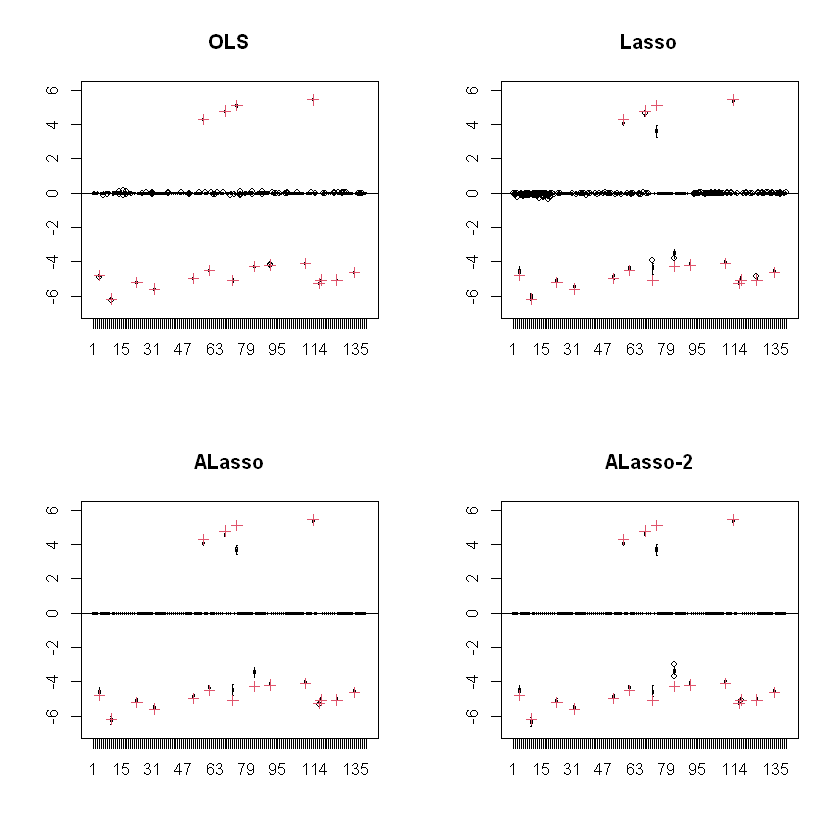

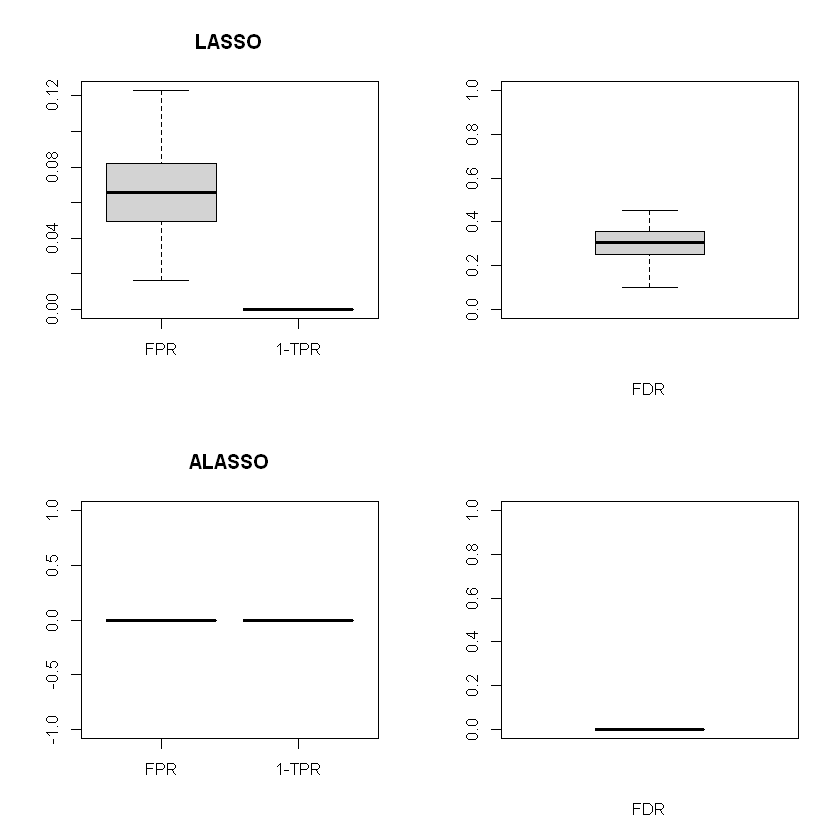

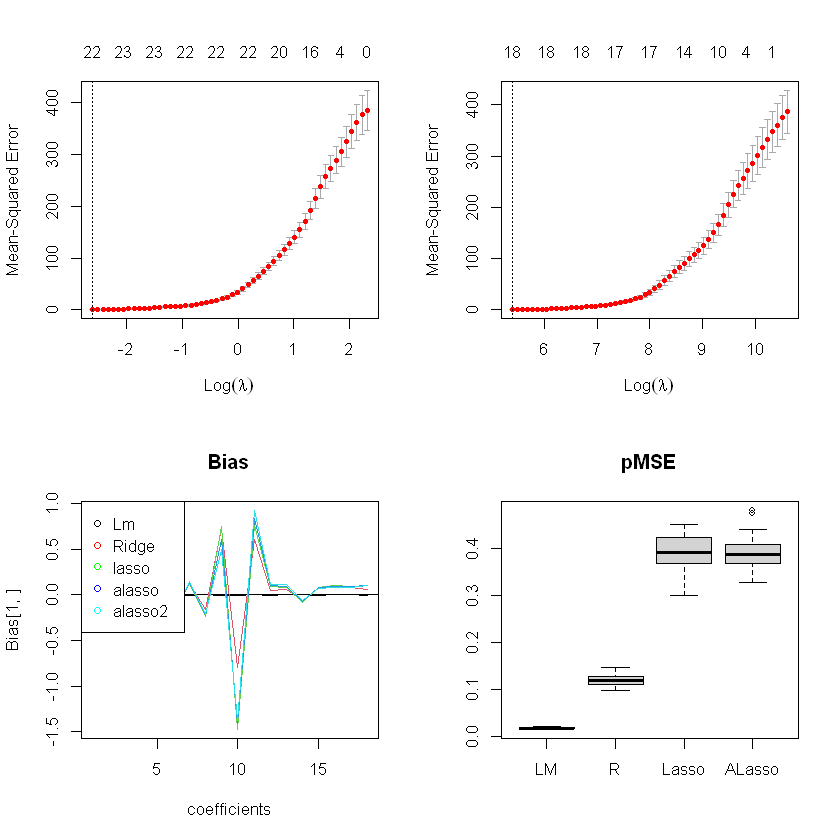

In [7]:
#### Model selection simulation ####

## Setup
library(glmnet)
library(MASS)

standardize <- function(x) {
  x <- (x - mean(x)) / sd(x)
}


set.seed(100100)
# Try different sample size (ns), noiselevel, correlation within groups of variables, size model
B<-25
ns<-200                     # larger sample size
noiselev<-0.1               # noise level
p<-c(20,50,20,50)           # how many features in each of 4 groups - change as you will
ps<-sum(p)                  # total number of features
pr<-0.1                     # proportion of features in true model
sigmean<-5                  # signal strength - how large true coefficients are is controlled
sigs<-0.5 
# 3 groups of variables that are correlated
grcorr1<-.3 # smaller value here makes xs in each group more correlated
grcorr2<-1
grcorr3<-.3
#
Truth<-rep(0,ps)
Truth<-round(rbinom(n=ps,size=1,prob=pr))
# generates the true model, either at random or by choice
#
# create matrices to store the results
Coeflm<-matrix(0,ps,B)
CoefR<-matrix(0,ps,B)
Coefla<-matrix(0,ps,B)
Coefala<-matrix(0,ps,B)
Coefala2<-matrix(0,ps,B)
MSElm<-matrix(0,B,1)
MSER<-matrix(0,B,1)
MSEla<-matrix(0,B,1)
MSEala<-matrix(0,B,1)
#
nt<-sum(Truth)
tr.coef<-rnorm(nt,mean=sigmean,sd=sigs)*sign(rbinom(n=nt,size=1,prob=.5)*2-1)
all.coef<-rep(0,ps)
all.coef[Truth==1]<-tr.coef
# coefficients in true model
for (b in (1:B)) {
  # create the x variabes in 3 correlated groups
  x1<-rnorm(ns)
  x1<-matrix(rep(x1,p[1]),ns,p[1],byrow=F)+matrix(rnorm(ns*p[1],sd=grcorr1),ns,p[1])
  x1<-apply(x1,2,standardize)
  #
  x2<-rnorm(ns)
  x2<-matrix(rep(x2,p[2]),ns,p[2],byrow=F)+matrix(rnorm(ns*p[2],sd=grcorr2),ns,p[2])
  x2<-apply(x2,2,standardize)
  #
  x3<-rnorm(ns)
  x3<-matrix(rep(x3,p[3]),ns,p[3],byrow=F)+matrix(rnorm(ns*p[3],sd=grcorr3),ns,p[3])
  x3<-apply(x3,2,standardize)
  #
  x4<-matrix(rnorm(ns*p[4]),ns,p[4])
  x4<-apply(x4,2,standardize)
  #
  y<-cbind(x1,x2,x3,x4)%*%all.coef+rnorm(ns)*noiselev
  df<-as.data.frame(cbind(x1,x2,x3,x4,y))
  names(df)<-c(as.character(seq(1,ps)),"y")
  ####
  y.new<-cbind(x1,x2,x3,x4)%*%all.coef+rnorm(ns)*noiselev
  df.new<-as.data.frame(cbind(x1,x2,x3,x4,y.new))
  names(df.new)<-c(as.character(seq(1,ps)),"y")
  #### Now data set is created
  # Run OLS if possible
  if (ns>ps) {
    mm<-lm(y~., data=df)
    Coeflm[,b]<-mm$coef[-1]
    pm<-predict(mm,newdata=df.new)
    MSElm[b]<-sum((y.new-pm)^2)/length(pm) }
  #
  # lasso
  cv.gg<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y)
  Coefla[,b]<-coef(cv.gg,s="lambda.1se")[-1]
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg,s="lambda.1se")
  MSEla[b]<-sum((y.new-pm)^2)/length(pm)
  #
  # adaptive lasso with ridge initialization
  gamma<-1
  ma<-lm.ridge(y~., data=df,lambda=1)
  CoefR[,b]<-coef(ma)[-1]
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(ma)
  MSER[b]<-sum((y.new-pm)^2)/length(pm)
  #
  ma<-lm.ridge(y~., data=df,lambda=.01)
  penf<-1/(abs(coef(ma)[-1])^gamma)
  cv.gg2<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y,penalty.factor=penf)
  cc<-coef(cv.gg2,s="lambda.1se")[-1]
  Coefala[,b]<-cc
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg2,s="lambda.1se")
  MSEala[b]<-sum((y.new-pm)^2)/length(pm)
  #
  # gamma=2
  gamma <- 2
  xx3<-cbind(x1,x2,x3,x4)%*%diag(abs(coef(ma)[-1])^gamma)
  gg3<-cv.glmnet(x=xx3,y=y,standardize=F)
  cc<-(coef(gg3,s="lambda.1se")[-1])*(abs(coef(ma)[-1])^gamma)
  Coefala2[,b]<-cc
  #####
}


# Result summaries
# Looking at all the coefficients
par(mfrow=c(2,2))
if (ns>ps) {
  boxplot(t(Coeflm),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="OLS") }
if (ns<=ps) {
  boxplot(t(CoefR),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="Ridge") }
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefla),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="Lasso")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefala),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="ALasso")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefala2),ylim=c(min(tr.coef)*1.1,max(tr.coef)*1.1),main="ALasso-2")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
####

if (ns>ps) {
Bias<-rbind(apply(Coeflm,1,mean)[Truth==1]-tr.coef,
            apply(CoefR,1,mean)[Truth==1]-tr.coef,
            apply(Coefla,1,mean)[Truth==1]-tr.coef,
            apply(Coefala,1,mean)[Truth==1]-tr.coef,
            apply(Coefala2,1,mean)[Truth==1]-tr.coef)

Var<-rbind(apply(Coeflm,1,var)[Truth==1],
           apply(CoefR,1,var)[Truth==1],
           apply(Coefla,1,var)[Truth==1],
           apply(Coefala,1,var)[Truth==1],
           apply(Coefala2,1,var)[Truth==1])
# bias and variance of each of the methods
row.names(Bias)<-c("LM","R","Lasso","aLasso","aLasso2")
row.names(Var)<-c("LM","R","Lasso","aLasso","aLasso2")
print("BIAS")
print(Bias)
print("VARIANCE")
print(Var)
}

if (ns<=ps) {
  Bias<-abs(rbind(apply(CoefR,1,mean)[Truth==1]-tr.coef,
              apply(Coefla,1,mean)[Truth==1]-tr.coef,
              apply(Coefala,1,mean)[Truth==1]-tr.coef,
              apply(Coefala2,1,mean)[Truth==1]-tr.coef))

  Var<-rbind(apply(CoefR,1,var)[Truth==1],
             apply(Coefla,1,var)[Truth==1],
             apply(Coefala,1,var)[Truth==1],
             apply(Coefala2,1,var)[Truth==1])
  # bias and variance of each of the methods
  row.names(Bias)<-c("R","Lasso","aLasso","aLasso2")
  row.names(Var)<-c("R","Lasso","aLasso","aLasso2")
  print("BIAS")
  print(Bias)
  print("VARIANCE")
  print(Var)
}
# store selection results
TPFP<-function(Coefs,truth) {
  tr<-truth
  cp<-Coefs
  TP<-length(cp[cp!=0 & tr==1])/length(tr[tr==1])
  FP<-length(cp[cp!=0 & tr==0])/length(tr[tr==0])
  FDR<-length(cp[cp!=0 & tr==0])/length(cp[cp!=0])
  return(list(FP=FP,FDR=FDR,TP=TP))
}

#
par(mfrow=c(2,2))
LassoSel<-apply(Coefla,2,TPFP,truth=Truth)
ll<-unlist(LassoSel)
boxplot(cbind(ll[seq(1,(B*3),by=3)],1-ll[seq(3,(B*3),by=3)]),names=c("FPR","1-TPR"),main="LASSO")
boxplot(ll[seq(2,(B*3),by=3)],xlab=c("FDR"),ylim=c(0,1))
ALassoSel<-apply(Coefala,2,TPFP,truth=Truth)
ll<-unlist(ALassoSel)
boxplot(cbind(ll[seq(1,(B*3),by=3)],1-ll[seq(3,(B*3),by=3)]),names=c("FPR","1-TPR"),main="ALASSO")
boxplot(ll[seq(2,(B*3),by=3)],xlab=c("FDR"),ylim=c(0,1))

#solution paths
plot(cv.gg)
plot(cv.gg2)
#mean bias across runs
plot(Bias[1,],type="l",ylim=c(min(Bias),max(Bias)),main="Bias",xlab="coefficients")
abline(h=0)
lines(Bias[2,],col=2)
lines(Bias[3,],col=3)
lines(Bias[4,],col=4)
if (ns > ps)   {
    lines(Bias[5,],col=5)
    legend("topleft",legend=c("Lm","Ridge","lasso","alasso","alasso2"),pch=1,col=c("black","red","green","blue","cyan"))
}
if (ns <= ps) {
    legend("topleft",legend=c("Ridge","lasso","alasso","alasso2"),pch=1,col=c("black","red","green","blue"))
}

#predictive performance
if (ns > ps) {
   boxplot(cbind(MSElm,MSER,MSEla,MSEala),names=c("LM","R","Lasso","ALasso"),main="pMSE") }
if (ns <= ps) {
   boxplot(cbind(MSER,MSEla,MSEala),names=c("R","Lasso","ALasso"),main="pMSE") }


Of course, with this much data both lasso and adaptive lasso do a great job selection the true coefficients. The predictive performance for all methods are good (check a scatter plot of prediction vs true values to verify). 


Let's now use the same simulation set up and compare lasso and elastic net. Remember from class that elastic net incorporates both a ridge and a lasso penalty - where the ridge penalty tends to allow for correlated features to enter the model together.

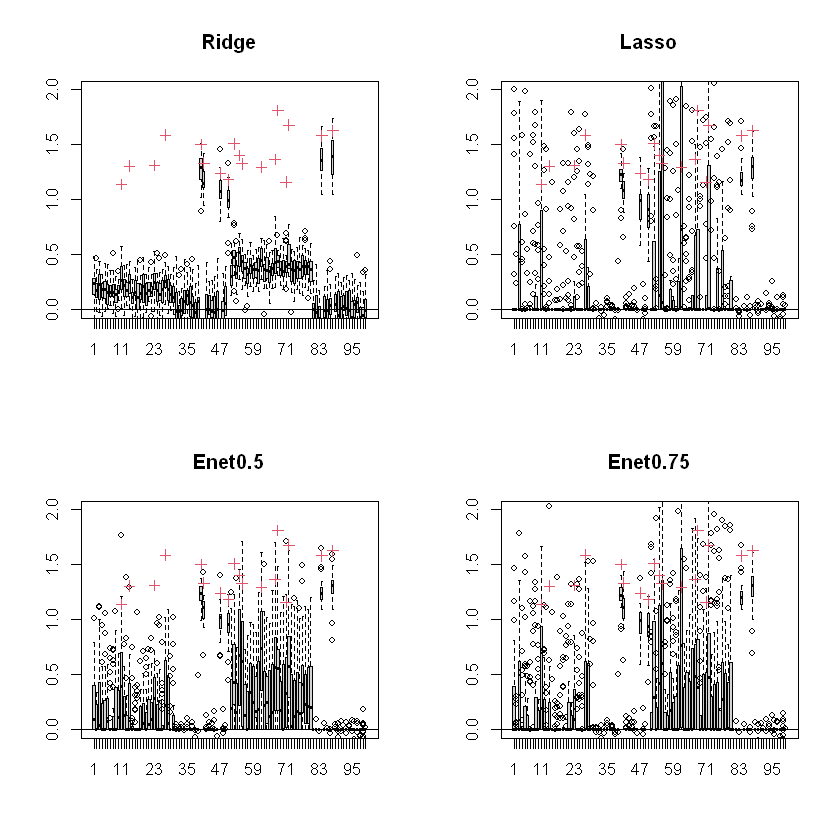

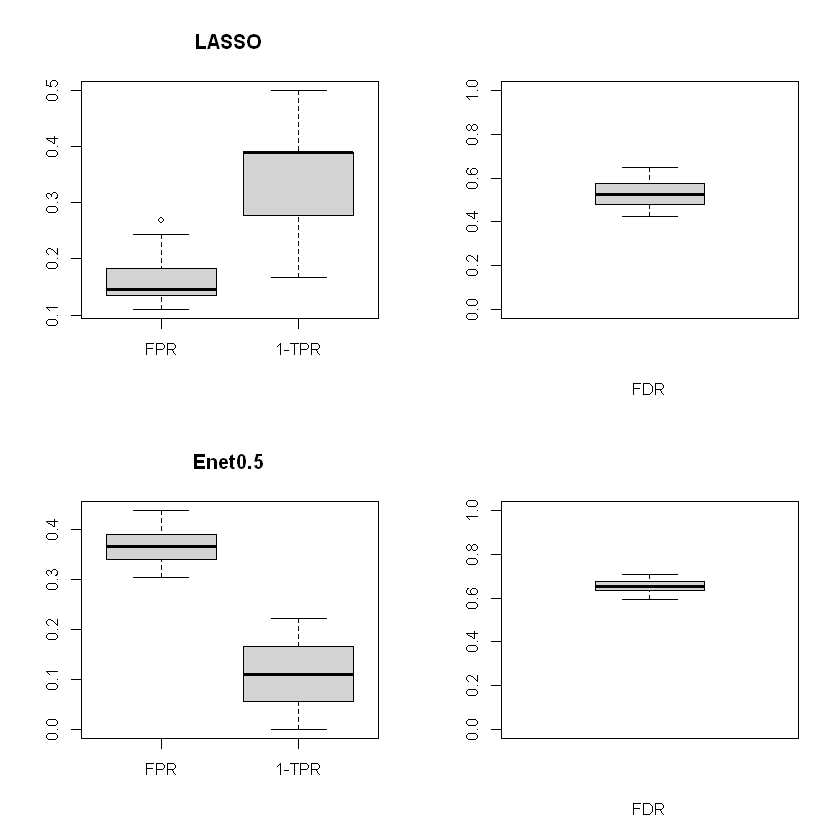

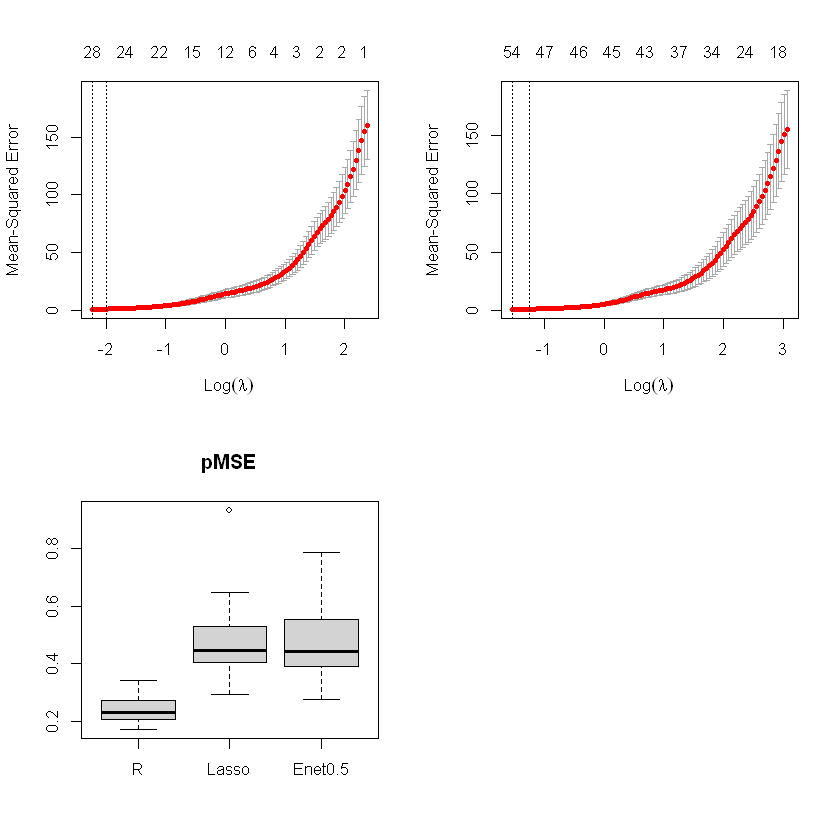

In [8]:
#### Model selection simulation ####

## Setup
library(glmnet)
library(MASS)

standardize <- function(x) {
  x <- (x - mean(x)) / sd(x)
}


#set.seed(100125)
set.seed(5667)
# Try different sample size (ns), noiselevel, correlation within groups of variables, size model
B<-25
ns<-50            # sample size
noiselev<-0.35    # noise level
p<-c(30,20,30,20) # how many features in each of 4 groups - change as you will
ps<-sum(p)        # total number of features
pr<-0.1           # proportion of features in true model
sigmean<-1.5
sigs<-0.15 # signal strength - how large true coefficients are
# 3 groups of variables that are correlated
grcorr1<-.1 # smaller value here makes xs in each group more correlated
grcorr2<-5
grcorr3<-.1
#
Truth<-rep(0,ps)
Truth<-round(rbinom(n=ps,size=1,prob=pr))
# generates the true model, either at random or by choice
#
# create matrices to store the results
Coeflm<-matrix(0,ps,B)
CoefR<-matrix(0,ps,B)
Coefla<-matrix(0,ps,B)
Coefala<-matrix(0,ps,B)
Coefala2<-matrix(0,ps,B)
MSElm<-matrix(0,B,1)
MSER<-matrix(0,B,1)
MSEla<-matrix(0,B,1)
MSEala<-matrix(0,B,1)
#
nt<-sum(Truth)
tr.coef<-rnorm(nt,mean=sigmean,sd=sigs) # here I made all coefficients positive because it was easier to visualize below
#*sign(rbinom(n=nt,size=1,prob=.5)*2-1) 
all.coef<-rep(0,ps)
all.coef[Truth==1]<-tr.coef
# coefficients in true model
for (b in (1:B)) {
  # create the x variabes in 3 correlated groups
  x1<-rnorm(ns)
  x1<-matrix(rep(x1,p[1]),ns,p[1],byrow=F)+matrix(rnorm(ns*p[1],sd=grcorr1),ns,p[1])
  x1<-apply(x1,2,standardize)
  #
  x2<-rnorm(ns)
  x2<-matrix(rep(x2,p[2]),ns,p[2],byrow=F)+matrix(rnorm(ns*p[2],sd=grcorr2),ns,p[2])
  x2<-apply(x2,2,standardize)
  #
  x3<-rnorm(ns)
  x3<-matrix(rep(x3,p[3]),ns,p[3],byrow=F)+matrix(rnorm(ns*p[3],sd=grcorr3),ns,p[3])
  x3<-apply(x3,2,standardize)
  #
  x4<-matrix(rnorm(ns*p[4]),ns,p[4])
  x4<-apply(x4,2,standardize)
  #
  y<-cbind(x1,x2,x3,x4)%*%all.coef+rnorm(ns)*noiselev
  df<-as.data.frame(cbind(x1,x2,x3,x4,y))
  names(df)<-c(as.character(seq(1,ps)),"y")
  ####
  y.new<-cbind(x1,x2,x3,x4)%*%all.coef+rnorm(ns)*noiselev
  df.new<-as.data.frame(cbind(x1,x2,x3,x4,y.new))
  names(df.new)<-c(as.character(seq(1,ps)),"y")
  #### Now data set is created
  # Run OLS if possible
  if (ns>ps) {
    mm<-lm(y~., data=df)
    Coeflm[,b]<-mm$coef[-1]
    pm<-predict(mm,newdata=df.new)
    MSElm[b]<-sum((y.new-pm)^2)/length(pm) }
  #
  # lasso
  cv.gg<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y)
  Coefla[,b]<-coef(cv.gg,s="lambda.1se")[-1]
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg,s="lambda.1se")
  MSEla[b]<-sum((y.new-pm)^2)/length(pm)
  #
  # Ridge
  gamma<-1
  ma<-lm.ridge(y~., data=df,lambda=1)
  CoefR[,b]<-coef(ma)[-1]
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(ma)
  MSER[b]<-sum((y.new-pm)^2)/length(pm)
  # elastic net, alpha =.5
  cv.gg2<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y,alpha=.5)
  cc<-coef(cv.gg2,s="lambda.1se")[-1]
  Coefala[,b]<-cc
  pm<-cbind(rep(1,ns),cbind(x1,x2,x3,x4))%*%coef(cv.gg2,s="lambda.1se")
  MSEala[b]<-sum((y.new-pm)^2)/length(pm)
  #
  # alpha = .75
  cv.gg3<-cv.glmnet(x=cbind(x1,x2,x3,x4),y=y,alpha=.75)
  cc<-coef(cv.gg3,s="lambda.1se")[-1]
  Coefala2[,b]<-cc
  #####
}


# Result summaries
# Looking at all the coefficients
par(mfrow=c(2,2))
if (ns>ps) {
  boxplot(t(Coeflm),ylim=c(0*min(tr.coef)*1.1,max(tr.coef)*1.1),main="OLS") }
if (ns<=ps) {
  boxplot(t(CoefR),ylim=c(0*min(tr.coef)*1.1,max(tr.coef)*1.1),main="Ridge") }
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefla),ylim=c(0*min(tr.coef)*1.1,max(tr.coef)*1.1),main="Lasso")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefala),ylim=c(0*min(tr.coef)*1.1,max(tr.coef)*1.1),main="Enet0.5")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
boxplot(t(Coefala2),ylim=c(0*min(tr.coef)*1.1,max(tr.coef)*1.1),main="Enet0.75")
abline(h=0)
points(seq(1,ps)[Truth==1],tr.coef,col=2,pch=3)
####

TPFP<-function(Coefs,truth) {
  tr<-truth
  cp<-Coefs
  TP<-length(cp[cp!=0 & tr==1])/length(tr[tr==1])
  FP<-length(cp[cp!=0 & tr==0])/length(tr[tr==0])
  FDR<-length(cp[cp!=0 & tr==0])/length(cp[cp!=0])
  return(list(FP=FP,FDR=FDR,TP=TP))
}
# selection results
par(mfrow=c(2,2))
LassoSel<-apply(Coefla,2,TPFP,truth=Truth)
ll<-unlist(LassoSel)
boxplot(cbind(ll[seq(1,(B*3),by=3)],1-ll[seq(3,(B*3),by=3)]),names=c("FPR","1-TPR"),main="LASSO")
boxplot(ll[seq(2,(B*3),by=3)],xlab=c("FDR"),ylim=c(0,1))
ALassoSel<-apply(Coefala,2,TPFP,truth=Truth)
ll<-unlist(ALassoSel)
boxplot(cbind(ll[seq(1,(B*3),by=3)],1-ll[seq(3,(B*3),by=3)]),names=c("FPR","1-TPR"),main="Enet0.5")
boxplot(ll[seq(2,(B*3),by=3)],xlab=c("FDR"),ylim=c(0,1))

#solution paths
plot(cv.gg)
plot(cv.gg2)

#predictive performance

if (ns > ps) {
   boxplot(cbind(MSElm,MSER,MSEla,MSEala),names=c("LM","R","Lasso","Enet0.5"),main="pMSE") }
if (ns <= ps) {
   boxplot(cbind(MSER,MSEla,MSEala),names=c("R","Lasso","Enet0.5"),main="pMSE") }


Here, group 1 and group 3 contained correlated features. Notice how ridge and elastic net tends to select all the features in the group as part of the model in a coordinated fashion.

Notice that Enet will have larger FPR because features may join the model based on their correlation with true predictors. Depending on the sample size, correlation structure etc, you may get a better TPR with elastic net. 

Notice how the lasso estimates are all over the place!

Try with different sample sizes, group correlations etc.

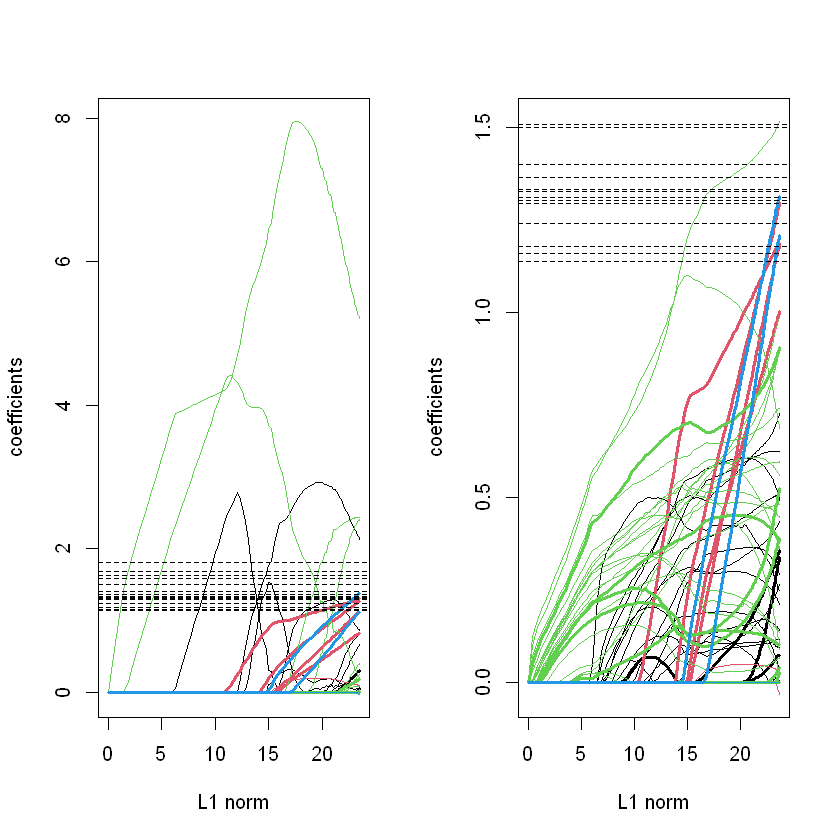

In [9]:
gg<-glmnet(x=cbind(x1,x2,x3,x4),y=y)
gg2<-glmnet(x=cbind(x1,x2,x3,x4),y=y,alpha=.5)
grcol<-c(rep(1,p[1]),rep(2,p[2]),rep(3,p[3]),rep(4,p[4]))
trlwd<-Truth*3
par(mfrow=c(1,2))
plot(apply(abs(gg$beta),2,sum),gg$beta[1,],type="l",ylim=c(min(gg$beta),max(gg$beta)),xlab="L1 norm",ylab="coefficients")
for (bb in (1:dim(gg$beta)[1])) {
    lines(apply(abs(gg$beta),2,sum),gg$beta[bb,],col=grcol[bb],lwd=trlwd[bb])
}
for (kk in (1:length(tr.coef))) {
    abline(h=tr.coef[kk],lty=2)
}
plot(apply(abs(gg2$beta),2,sum),gg2$beta[1,],type="l",ylim=c(min(gg2$beta),max(gg2$beta)),xlab="L1 norm",ylab="coefficients")
for (bb in (1:dim(gg$beta)[1])) {
    lines(apply(abs(gg2$beta),2,sum),gg2$beta[bb,],col=grcol[bb],lwd=trlwd[bb])
}
for (kk in (1:length(tr.coef))) {
    abline(h=tr.coef[kk],lty=2)
} # solution paths for lasso (left) and elastic net (right)

The black and green curves are the 1st and 3rd group of features, respectively. Notice how the elastic net (right panel) produced solution paths that tend to select many of the green and black features. The wider lines are the true features. Notice that while elastic net picks many features, the true ones tend to be included early on.

The lasso (left panel) really struggles here. Notice that it "randomly" selects one of the group features (not the true one) early on while the true ones are not even part of the model until almost no penalty is applied.

Try with less correlation, bigger/smaller groups etc and see what happens.